# Data Science Project: Planning Report  
UBC Minecraft Research Server  
Abhijeet Kaler 
DSCI 100  

## 1. Data Description

This project uses two datasets from a Minecraft research server run by a UBC Computer Science group. Players voluntarily joined the server, their gameplay sessions were logged automatically, and they completed a short questionnaire, giving us both behavioural and self-reported data.

### players.csv  
This file contains **196 players** and **7 variables**:

- `experience` (factor): self-reported Minecraft skill level.  
- `subscribe` (logical): newsletter opt-in.  
- `hashedEmail` (ID): anonymous player identifier.  
- `played_hours` (numeric): total hours spent on the server.  
- `name` (character): first name only.  
- `gender` (factor): self-reported gender.  
- `Age` (numeric): age in years (some missing).

### sessions.csv  
This file contains **1535 sessions** and **5 variables**:

- `hashedEmail` (ID): links sessions to players.  
- `start_time`, `end_time` (character): readable timestamps.  
- `original_start_time`, `original_end_time` (numeric): timestamps in milliseconds.

### Data Issues  
Several issues appeared during exploration:

- **Missing values:** Some ages are missing, and some sessions lack end times.  
- **Skewed data:** `played_hours` is extremely right-skewed—most players have low hours while a few contribute very high amounts.  
- **Self-report bias:** Variables like experience and gender may not be perfectly accurate.  
- **Selection bias:** Only players who opted into the research server are represented.  
- **Irrelevant variables:** `name` will not be used in modelling.

For now, the player-level dataset is the focus since it contains the response variable of interest. Later, I may aggregate `sessions.csv` (e.g., session count, average session duration) to create additional predictors.


## 2. Questions

**Broad question:**  
Which types of players are most likely to contribute large amounts of data?

**Specific question:**  
Can player demographics and experience (`Age`, `gender`, `experience`, `subscribe`) predict total hours played (`played_hours`) on the research server?

`played_hours` directly measures data contribution, and the predictors describe player characteristics. This planning stage focuses on understanding these variables before doing any modelling.


In [15]:

library(tidyverse)
library(lubridate)

players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

glimpse(players)
glimpse(sessions)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+

In [16]:
players <- players %>% 
  mutate(
    experience = as.factor(experience),
    gender     = as.factor(gender),
    subscribe  = as.logical(subscribe)
  )

sessions <- sessions %>% 
  mutate(
    start_time = dmy_hm(start_time),
    end_time   = dmy_hm(end_time),
    session_hours = (original_end_time - original_start_time) / (1000 * 60 * 60)
  )

players_means <- players %>% 
  summarise(across(where(is.numeric), ~ round(mean(.x, na.rm = TRUE), 2))) %>% 
  pivot_longer(everything(),
               names_to = "variable",
               values_to = "mean")

players_means

variable,mean
<chr>,<dbl>
played_hours,5.85
Age,21.14


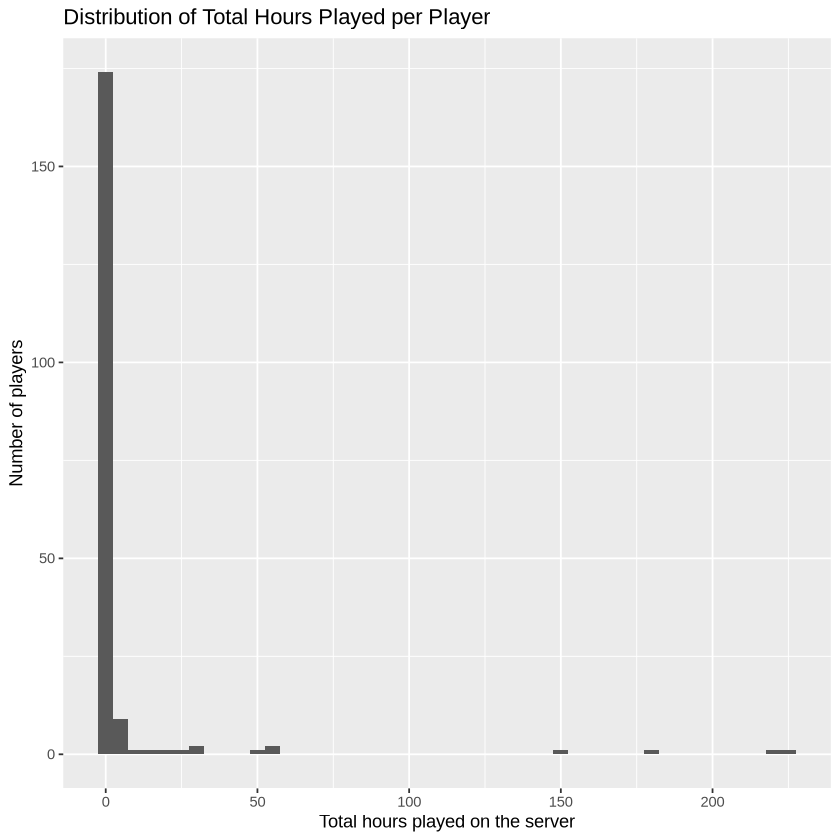

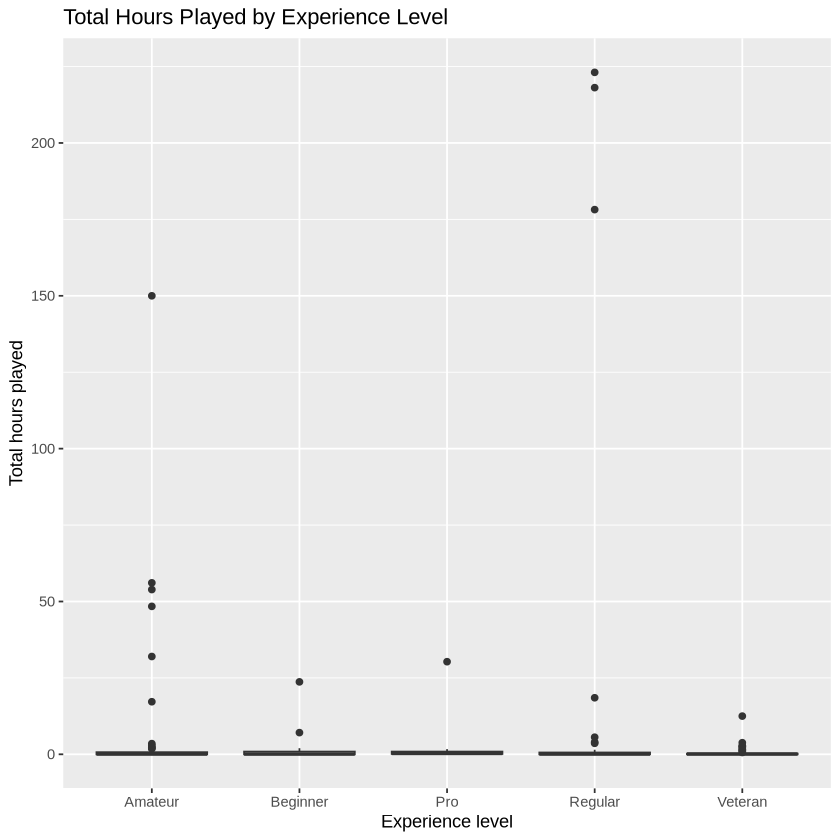

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


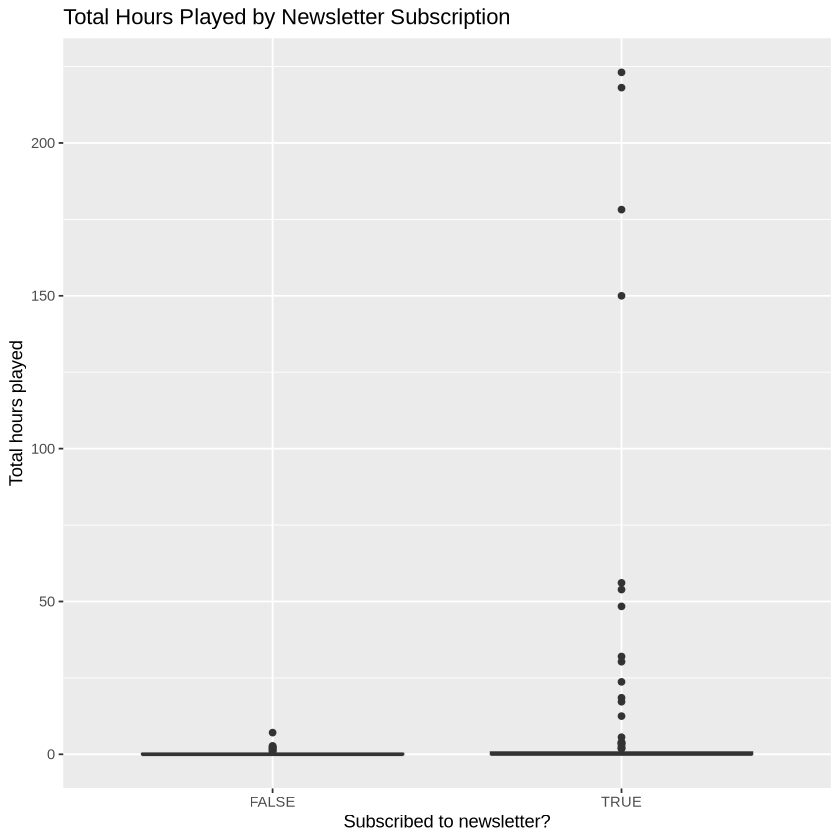

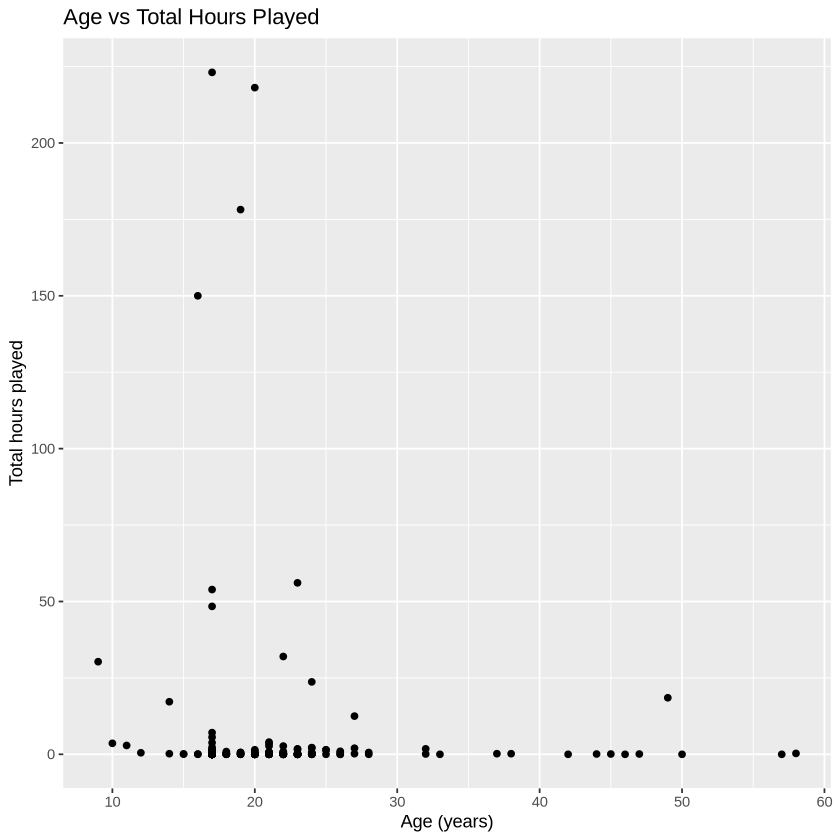

In [17]:
ggplot(players, aes(x = played_hours)) +
  geom_histogram(binwidth = 5) +
  labs(
    title = "Distribution of Total Hours Played per Player",
    x = "Total hours played on the server",
    y = "Number of players"
  )

ggplot(players, aes(x = experience, y = played_hours)) +
  geom_boxplot() +
  labs(
    title = "Total Hours Played by Experience Level",
    x = "Experience level",
    y = "Total hours played"
  )

ggplot(players, aes(x = subscribe, y = played_hours)) +
  geom_boxplot() +
  labs(
    title = "Total Hours Played by Newsletter Subscription",
    x = "Subscribed to newsletter?",
    y = "Total hours played"
  )

ggplot(players, aes(x = Age, y = played_hours)) +
  geom_point() +
  labs(
    title = "Age vs Total Hours Played",
    x = "Age (years)",
    y = "Total hours played"
  )


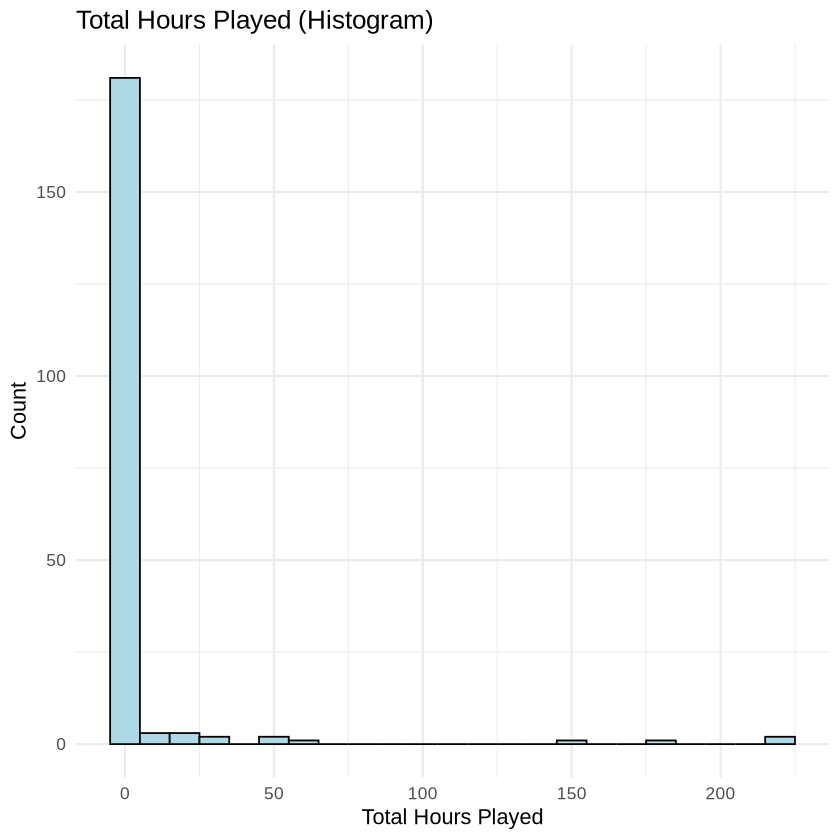

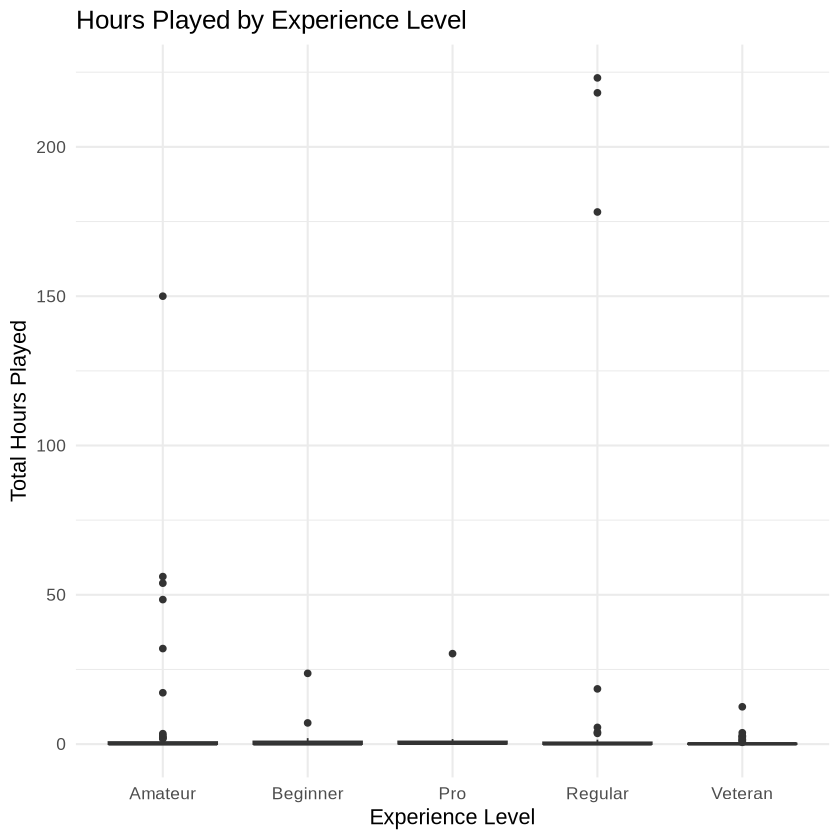

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


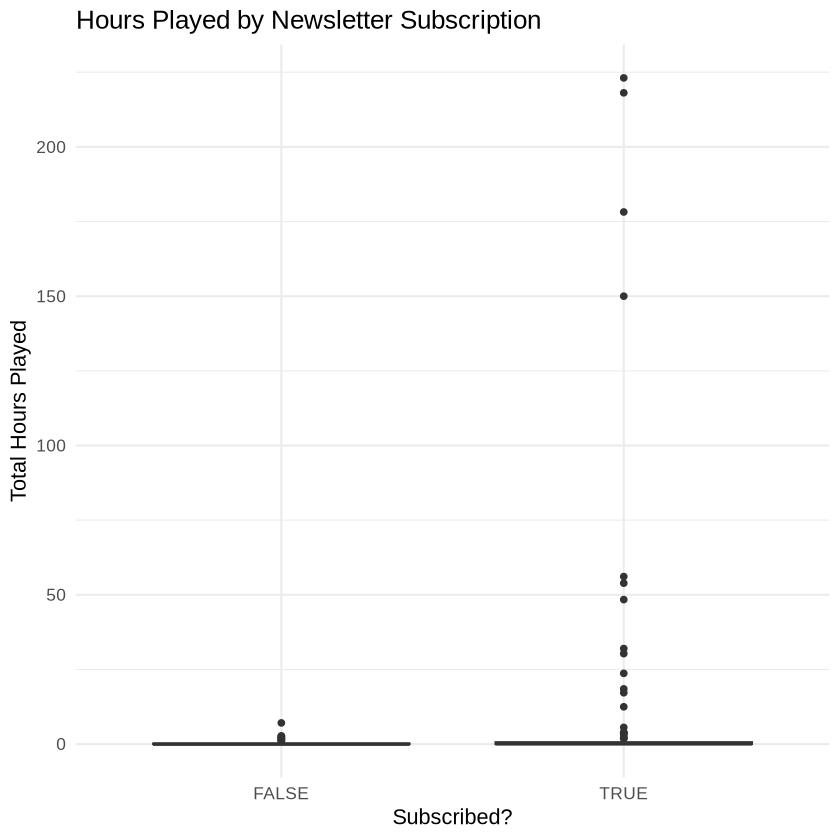

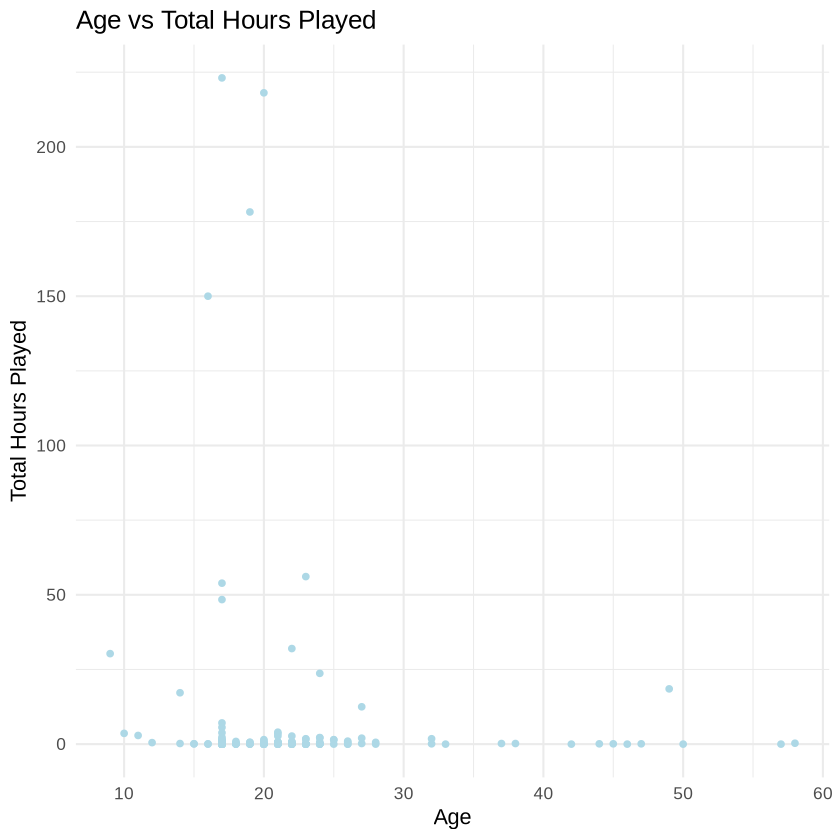

In [18]:

simple_theme <- theme_minimal(base_size = 13)

ggplot(players, aes(x = played_hours)) +
  geom_histogram(binwidth = 10, fill = "lightblue", color = "black") +
  labs(
    title = "Total Hours Played (Histogram)",
    x = "Total Hours Played",
    y = "Count"
  ) +
  simple_theme


ggplot(players, aes(x = experience, y = played_hours)) +
  geom_boxplot(fill = "lightblue") +
  labs(
    title = "Hours Played by Experience Level",
    x = "Experience Level",
    y = "Total Hours Played"
  ) +
  simple_theme


ggplot(players, aes(x = subscribe, y = played_hours)) +
  geom_boxplot(fill = "lightblue") +
  labs(
    title = "Hours Played by Newsletter Subscription",
    x = "Subscribed?",
    y = "Total Hours Played"
  ) +
  simple_theme


ggplot(players, aes(x = Age, y = played_hours)) +
  geom_point(color = "lightblue") +
  labs(
    title = "Age vs Total Hours Played",
    x = "Age",
    y = "Total Hours Played"
  ) +
  simple_theme


## 3. Exploratory Data Analysis and Visualization

A histogram shows `played_hours` is highly right-skewed, with most players contributing little and a few contributing a lot. The experience boxplot suggests more experienced players tend to record more hours. Comparing subscription groups shows slightly higher hours among subscribers, but with overlap. The Age scatterplot shows no strong linear trend, though some younger and mid-range ages have higher playtime. Overall, multiple variables seem related to `played_hours`.



## 4. Methods and Plan

I plan to use **k-nearest neighbours (k-NN regression)** to predict `played_hours` from `Age`, `gender`, `experience`, and `subscribe`. This method is suitable because the relationship between predictors and playtime is likely non-linear, and k-NN makes minimal assumptions.

However, k-NN is sensitive to scaling, outliers, and the choice of *k*. The skewness of `played_hours` may also affect performance, so a transformation may be considered during the full project.

I will split the data into **80% training** and **20% test** sets. All preprocessing (handling missing values, scaling numeric variables, encoding factors) will occur in a recipe fitted only on the training data. I will use cross-validation on the training set to tune *k*, using RMSE or RMSPE. The final model will be evaluated once on the separate test set to estimate predictive accuracy.
